In [27]:
import numpy as np
import pandas as pd
import math
import scipy
import sklearn
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
from scipy.stats import spearmanr, pearsonr
import scipy.stats
import random

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt 
import seaborn as sns 

# Model Hyper-Parameters

In [236]:
num_task = 3

In [250]:
Data_train  = pd.read_csv('Train.csv')
Data_test = pd.read_csv('Test.csv')

X = Data_train['x']
X  = X.values.reshape((len(X), 1))
Y = Data_train['y']

X_test = Data_test['x']
X_test  = X_test.values.reshape((len(X_test), 1))
Y_test = Data_test['y']

In [7]:
def getPrediction(X, Y, X1):
    gp = GaussianProcessRegressor(kernel=kernels.DotProduct(), optimizer='fmin_l_bfgs_b' , alpha=1e-10, normalize_y=True)
    gp.fit(X, Y)
    return gp.predict(X1)


def getFullCorrelation(X, T, Y, num_task):
    PredictionFunctions = np.zeros((len(X) , num_task ))
    Correlations = np.zeros((num_task, num_task))
    if (Correlations.shape[0] != num_task ):
        print(Correlations.shape[0], num_task)
        print('ERROR - NUMBER OF TASKS NOT MATCHING- getFULLCorr !!!')
        return 0
    
    for t in range(0, num_task):
        X_t = X[T == t]
        Y_t = Y[T == t]
        PredictionFunctions[:, t] = getPrediction(X_t, Y_t, X)
    for i in range(0, num_task):
        for j in range(i, num_task):
            Correlations[i, j] = np.cov(PredictionFunctions[:, i], PredictionFunctions[:, j])[0, 1]
            Correlations[j , i] = Correlations[i, j]
    return PredictionFunctions, Correlations

In [335]:
# def kernelfunction(a, b):
#     return  math.exp(-1*(np.dot(a-b , a-b) + 1)  )

# def kernelfunction(a, b):
#     return  np.dot(a, b) + 1

def kernelfunction(a, b):
    return  np.dot(a, b)*np.dot(a, b) + np.dot(a, b) + 1

# def kernelfunction(a, b):
#     return  np.dot(a, b)*np.dot(a, b)*np.dot(a, b) + np.dot(a, b)*np.dot(a, b) + np.dot(a, b) + 1



def MTGPPredict(x_new, t_new, X, T, alpha, Cn_inv, Correlations, sigma2):
    N = len(X)
    Knew = np.zeros(N)
    for i in range(N):
        Knew[i] = kernelfunction(x_new, X[i])*Correlations[t_new , T[i]]
    mean = np.dot(Knew, alpha)
    var1 = np.dot(np.dot(Knew, Cn_inv) , Knew)
    var =  kernelfunction(x_new, x_new)*Correlations[t_new , t_new] + sigma2 - var1
    return mean, var



def MTGP(X, T, Y, X_pred, T_pred, Correlations , sigma2 , num_task):
    
    if (Correlations.shape[0] != num_task):
        print(Correlations.shape[0], num_task)
        print('ERROR - NUMBER OF TASKS NOT MATCHING !!!')
        return 0
    
    N = len(X)    
    Cn = np.zeros((N, N))
    
    for i in range(0, N):
        for j in range(i, N):
            Cn[i, j] = kernelfunction(X[i],  X[j])*Correlations[T[i] , T[j]]
            Cn[j , i] = Cn[i , j]
            
    Cn = Cn + sigma2*np.identity(N)
    
    Cn_inv = np.linalg.inv(Cn)
    alpha = np.dot(Cn_inv, Y)
    
    Y_pred_mean = np.zeros(len(X_pred))
    Y_pred_var = np.zeros(len(X_pred))
    
    for i in range(len(X_pred)):
        Y_pred_mean[i], Y_pred_var[i] = MTGPPredict(X_pred[i] , T_pred[i] , X, T,alpha, Cn_inv, Correlations , sigma2 )
    return Y_pred_mean, Y_pred_var


def MakeTask(T):
    dictionary = dict( zip(list(set(T)) , np.arange(len(set(T))))  )
    for i in range(len(T)):
        T[i] = dictionary[T[i]]
    return T
        

Fit on train Data


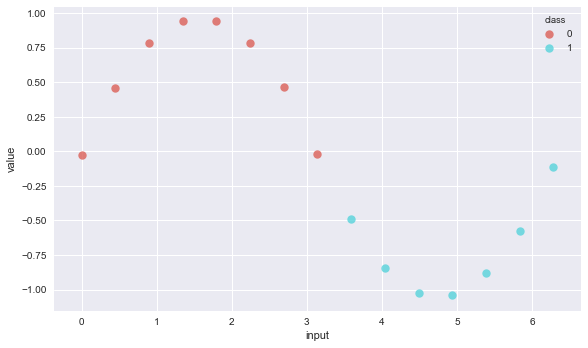

Fit on Test Data


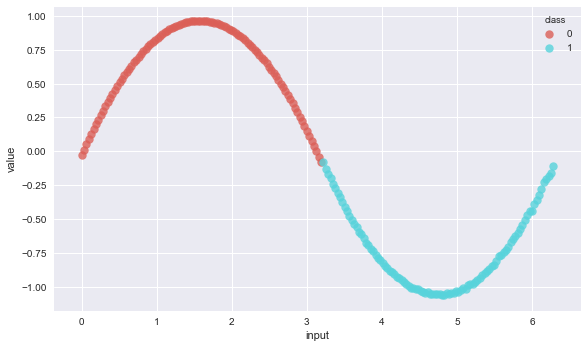

True Data


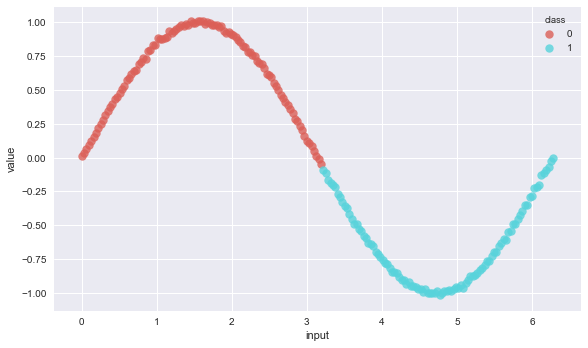

Single Task 


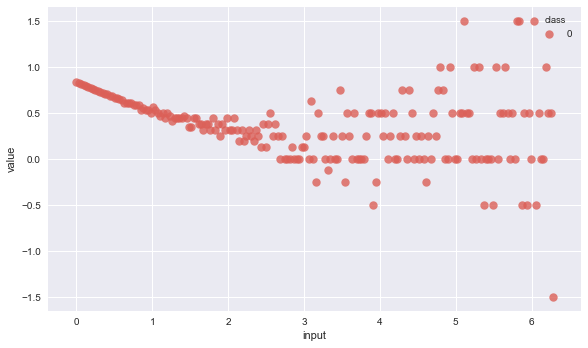

In [340]:
from sklearn.mixture import GMM

gmm = GMM(n_components=2)
gmm.fit(X)

T = gmm.predict(X)
T = MakeTask(T)

T_test = gmm.predict(X_test)
T_test = MakeTask(T_test)

num_task = len(set(T))
PredictionFunctions, Correlations = getFullCorrelation(X, T, Y, num_task)
print('Fit on train Data')
Y_pred_mean, Y_pred_var = MTGP(X, T, Y, X, T , Correlations , 1e-13 , num_task)
# print((X, Y_pred_mean))
fr =pd.DataFrame({'class' : T, 'value': Y_pred_mean, 'input' : X[:, 0]})
plotPoints(fr)

print('Fit on Test Data')
Y_pred_mean, Y_pred_var = MTGP(X, T, Y, X_test, T_test , Correlations , 1e-13 , num_task)
# print((X_test, Y_pred_mean))
fr =pd.DataFrame({'class' : T_test, 'value': Y_pred_mean, 'input' : X_test[:, 0]})
plotPoints(fr)

print('True Data')
fr =pd.DataFrame({'class' : T_test, 'value': Y_test, 'input' : X_test[:, 0]})
plotPoints(fr)

T = np.array( np.zeros(len(X)) )
T = MakeTask(T)
T = T.astype(int)

T_test = np.array( np.zeros(len(X_test)) )
T_test = MakeTask(T_test)
T_test = T_test.astype(int)

num_task = len(set(T))
PredictionFunctions, Correlations = getFullCorrelation(X, T, Y, num_task)

Y_pred_mean, Y_pred_var = MTGP(X, T, Y, X_test, T_test , Correlations , 1e-13 , num_task)
print('Single Task ')
fr =pd.DataFrame({'class' : T_test, 'value': Y_pred_mean, 'input' : X_test[:, 0]})
plotPoints(fr)


In [156]:
def plotPoints(fr):
    sns.lmplot(x='input' , y='value', data=fr, hue='class',palette='hls', fit_reg=False,size= 5, aspect=5/3, legend_out=False,scatter_kws={"s": 70})
    plt.show()
    

def plotLine(fr):
    sns.pointplot(x='input' , y='value', data=fr, hue='class',palette='hls', fit_reg=False,size= 5, aspect=5/3, legend_out=False,scatter_kws={"s": 70})
    plt.show()



In [155]:
N = len(X)    
Cn = np.zeros((N, N))

for i in range(0, N):
    for j in range(i, N):
        Cn[i, j] = kernelfunction(X[i],  X[j])*Correlations[T[i] , T[j]]
        Cn[j , i] = Cn[i , j]

Cn = Cn + 1e-12*np.identity(N)

A = Cn.copy()

Cn_inv = np.linalg.inv(A)

np.matmul(Cn, Cn_inv)

array([[ 9.99873862e-01, -8.66212882e-04,  1.13659355e-04, ...,
         2.31686842e-03, -2.58336381e-03, -7.37357560e-03],
       [-1.76946531e-04,  9.99114414e-01, -1.74016961e-04, ...,
        -9.13908989e-04,  5.70884276e-04, -4.35459957e-03],
       [ 1.82926744e-05, -7.48555999e-04,  9.99822502e-01, ...,
        -8.79305535e-04, -8.21986780e-04, -3.77702979e-03],
       ...,
       [-1.26211230e-03,  6.18376017e-05, -8.99273038e-04, ...,
         1.00074093e+00, -9.76621575e-04, -4.88534723e-03],
       [-9.93995135e-04,  1.10993444e-04, -5.42643563e-04, ...,
        -5.79206189e-03,  1.00000000e+00,  0.00000000e+00],
       [ 2.83149311e-04,  1.49365401e-03, -1.24035216e-04, ...,
         1.55290559e-03,  9.05609131e-03,  9.88861084e-01]])